# Lithology classification using Hugging Face, part 3
> First working lithology classification training on the Namoi data 

- toc: true
- badges: true
- comments: true
- categories: [hugging-face, NLP, lithology]
- author: J-M


# About

This is a continuation of [Lithology classification using Hugging Face, part 2](https://jmp75.github.io/work-blog/hugging-face/nlp/lithology/2022/06/13/lithology-classification-hugging-face-2.html).

The "Part 2" post ended up on an error on calling `trainer.train`, with incompatible tensor dimensions in a tensor multiplication. It was not clear at all (to me) what the root issue was. After getting back to basics and looking at the [HF Text classification how-to](https://huggingface.co/docs/transformers/main/en/tasks/sequence_classification), I noticed that my Dataset contained pytorch tensors or lists thereof, where the how-do just had simple data types. 

Long story short, I removed the tokernizer's parameter `return_tensors="pt",`  and did not call `tok_ds.set_format("torch")`, and surprised, it worked. I had added these because the initial trial complained about a mix of GPU and CPU data. 

## Plan

At this stage, it is worthwhile laying out a roadmap of where this line of work may go:

* Complete a classification on at least a subset of the Namoi dataset (this post)
* Upload a trained model to Hugging Face Hub, or perhaps [fastai X Hugging Face Group 2022](https://huggingface.co/hugginglearners)
* Set up a Gradio application on HF Spaces
* Project proposal at work. Weekend self-teaching can only go so far.


# Walkthrough

Much of the code in this section is very similar to [Lithology classification using Hugging Face, part 2](https://jmp75.github.io/work-blog/hugging-face/nlp/lithology/2022/06/13/lithology-classification-hugging-face-2.html), so blocks will be less commented.


In [1]:
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from pathlib import Path
from datasets import ClassLabel
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve,confusion_matrix,auc
import matplotlib.pyplot as plt
from collections import Counter

# Some column string identifiers
MAJOR_CODE = "MajorLithCode"
MAJOR_CODE_INT = "MajorLithoCodeInt"  # We will create a numeric representation of labels, which is (I think?) required by HF.
MINOR_CODE = "MinorLithCode"
DESC = "Description"

fn = Path("~").expanduser() / "data/ela/shp_namoi_river/NGIS_LithologyLog.csv"
litho_logs = pd.read_csv(
    fn, dtype={"FromDepth": str, "ToDepth": str, MAJOR_CODE: str, MINOR_CODE: str}
)

def token_freq(tokens, n_most_common=50):
    list_most_common = Counter(tokens).most_common(n_most_common)
    return pd.DataFrame(list_most_common, columns=["token", "frequency"])

litho_classes = litho_logs[MAJOR_CODE].values
df_most_common = token_freq(litho_classes, 50)

NUM_CLASSES_KEPT=17

labels_kept = df_most_common["token"][:NUM_CLASSES_KEPT].values 
labels_kept = labels_kept[labels_kept != "None"]
labels_kept

array(['CLAY', 'GRVL', 'SAND', 'SHLE', 'SDSN', 'BSLT', 'TPSL', 'SOIL',
       'ROCK', 'GRNT', 'SDCY', 'SLSN', 'CGLM', 'MDSN', 'UNKN', 'COAL'],
      dtype=object)

In [2]:
kept = [x in labels_kept for x in litho_classes]
litho_logs_kept = litho_logs[kept].copy()  # avoid warning messages down the track.
labels = ClassLabel(names=labels_kept)
int_labels = np.array([
    labels.str2int(x) for x in litho_logs_kept[MAJOR_CODE].values
])
int_labels = int_labels.astype(np.int8) # to mimick chapter3 HF so far as I can see
litho_logs_kept[MAJOR_CODE_INT] = int_labels

We will fine tune a smaller version of [DeBERTaV3: Improving DeBERTa using ELECTRA-Style Pre-Training with Gradient-Disentangled Embedding Sharing](https://huggingface.co/microsoft/deberta-v3-small) available on the Hugging Face model repository.

In [3]:
STARTING_MODEL = "microsoft/deberta-v3-small"

## Dealing with imbalanced classes with weights

In [4]:
sorted_counts = litho_logs_kept[MAJOR_CODE].value_counts()
class_weights = (1 - sorted_counts / sorted_counts.sum()).values
class_weights = torch.from_numpy(class_weights).float().to("cuda")

## Tokenisation

In [5]:
p = Path("./tokz_pretrained")
pretrained_model_name_or_path = p if p.exists() else STARTING_MODEL

# Tokenizer max length
max_length = 128

# https://discuss.huggingface.co/t/sentence-transformers-paraphrase-minilm-fine-tuning-error/9612/4
tokz = AutoTokenizer.from_pretrained(pretrained_model_name_or_path, use_fast=True, max_length=max_length, model_max_length=max_length)
if not p.exists():
    tokz.save_pretrained("./tokz_pretrained")

We know from the previous post that we should work with lowercase descriptions to have a more sensible tokenisation

In [6]:
litho_logs_kept[DESC] = litho_logs_kept[DESC].str.lower()
litho_logs_kept_mini = litho_logs_kept[[MAJOR_CODE_INT, DESC]]
litho_logs_kept_mini.sample(n=10)

,MajorLithoCodeInt,Description
88691,3,shale
77323,11,siltstone
42318,0,clay fine sandy water supply
85089,1,"gravel; as above, except gravels 70% 2-10mm, 3..."
112223,0,"clay; 70%, light brown. coarse sand to fine gr..."
35510,0,clay
106351,0,clay
80478,0,clay; ligth grey with brown streaks - with som...
20290,1,gravel
23426,0,"clay, gravelly, blueish"


## Create dataset and tokenisation

We will use a subset sample of the full dataset to train on, for the sake of execution speed, for now

In [7]:
len(litho_logs_kept_mini)

123657

In [8]:
litho_logs_kept_mini_subset = litho_logs_kept_mini.sample(len(litho_logs_kept_mini) // 4)
len(litho_logs_kept_mini_subset)

30914

In [9]:
ds = Dataset.from_pandas(litho_logs_kept_mini_subset)

def tok_func(x):
    return tokz(
        x[DESC],
        padding="max_length",
        truncation=True,
        max_length=max_length,
        # return_tensors="pt", ## IMPORTANT not to use return_tensors="pt" here, perhaps conter-intuitively
    )

In [10]:
tok_ds = ds.map(tok_func)
num_labels = len(labels_kept)

Parameter 'function'=<function tok_func at 0x7f49f6e17a60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/30914 [00:00<?, ?ex/s]

In [11]:
# NOTE: the local caching may be superflous
p = Path("./model_pretrained")

model_name = p if p.exists() else STARTING_MODEL
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, max_length=max_length)
                                                           # label2id=label2id, id2label=id2label).to(device) 
if not p.exists():
    model.save_pretrained(p)

In [12]:
print(type(model))

<class 'transformers.models.deberta_v2.modeling_deberta_v2.DebertaV2ForSequenceClassification'>


In [13]:
tok_ds = tok_ds.rename_columns({MAJOR_CODE_INT: "labels"})

In [14]:
# Keep the description column, which will be handy later despite warnings at training time.
tok_ds = tok_ds.remove_columns(['__index_level_0__'])
# tok_ds = tok_ds.remove_columns(['Description', '__index_level_0__'])

In [15]:
# Not sure why, but cannot set the labels class otherwise `train_test_split` complains
# tok_ds.features['labels'] = labels
dds = tok_ds.train_test_split(test_size=0.25, seed=42)

In [16]:
# Defining the Trainer to compute Custom Loss Function, adapted from [Simple Training with the 🤗 Transformers Trainer, around 840 seconds](https://youtu.be/u--UVvH-LIQ?t=840)
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Feed inputs to model and extract logits
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Extract Labels
        labels = inputs.get("labels")
        # Define loss function with class weights
        loss_func = torch.nn.CrossEntropyLoss(weight=class_weights)
        # Compute loss
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [17]:
def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    predictions = eval_pred.predictions.argmax(-1)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"f1": f1}

In [18]:
output_dir = "./hf_training"
batch_size = 64 # 128 causes a CUDA out of memory exception... Maybe I shoudl consider dynamic padding instead. Later.
epochs = 3 # low, but for didactic purposes will do.
lr = 8e-5  # inherited, no idea whether appropriate. is there an lr_find in hugging face?

In [19]:
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    learning_rate=lr,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size * 2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_steps=len(dds["train"]),
    fp16=True,
    push_to_hub=False,
    report_to="none",
)

In [20]:
model = model.to("cuda:0")

The above nay not be strictly necessary, depending on your version of `transformers`. I bumped into the following issue, which was probably the transformers [4.11.3 bug](https://github.com/nlp-with-transformers/notebooks/issues/31#issuecomment-1075369210): `RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper__index_select)`

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dds["train"],
    eval_dataset=dds["test"],
    tokenizer=tokz,
    compute_metrics=compute_metrics,
)

Using amp half precision backend


## Training


In [22]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Description. If Description are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/home/per202/miniconda/envs/hf/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 23185
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1089


Epoch,Training Loss,Validation Loss,F1
1,No log,0.072295,0.983439
2,No log,0.063188,0.985492
3,No log,0.061934,0.986534


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Description. If Description are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7729
  Batch size = 128
Saving model checkpoint to ./hf_training/checkpoint-500
Configuration saved in ./hf_training/checkpoint-500/config.json
Model weights saved in ./hf_training/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./hf_training/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./hf_training/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Description. If Description are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Runn

TrainOutput(global_step=1089, training_loss=0.16952454397938907, metrics={'train_runtime': 297.9073, 'train_samples_per_second': 233.479, 'train_steps_per_second': 3.655, 'total_flos': 2304099629568000.0, 'train_loss': 0.16952454397938907, 'epoch': 3.0})

## Exploring results

This part is newer compared to the previous post, so I will elaborate a bit.

I am not across the high level facilities to assess model predictions (visualisation, etc.) so what follows may be sub-optimal and idiosyncratic.


In [23]:
test_pred = trainer.predict(trainer.eval_dataset)

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: Description. If Description are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 7729
  Batch size = 128


In [24]:
test_pred

PredictionOutput(predictions=array([[-0.519 , -2.127 ,  0.61  , ..., -1.751 , -1.145 , -2.832 ],
       [ 0.8223,  2.123 ,  9.27  , ..., -3.254 , -0.8325, -1.929 ],
       [-1.003 , -0.469 , -1.233 , ..., -1.084 , -0.7856, -0.4966],
       ...,
       [-0.53  , -1.396 , -0.5615, ..., -2.506 , -1.985 , -3.44  ],
       [-0.453 , -1.442 , -0.621 , ..., -2.424 , -1.973 , -3.44  ],
       [-1.388 , -2.346 , -1.186 , ..., -1.94  , -0.6084, -2.22  ]],
      dtype=float16), label_ids=array([4, 2, 8, ..., 5, 5, 6]), metrics={'test_loss': 0.061934199184179306, 'test_f1': 0.9865336898918051, 'test_runtime': 8.7643, 'test_samples_per_second': 881.873, 'test_steps_per_second': 6.96})

This is lower level than I anticipated. The predictions array appear to be the `logits`. Note that I was not sure `label_ids` was, and it is **not** the predicted label, but the "true" label.

In [25]:
test_df = trainer.eval_dataset.to_pandas()
y_true = test_df.labels.values.astype(int)
y_true

array([4, 2, 8, ..., 5, 5, 6])

To get the predicted labels, I seem to need to do the following song and dance:

In [26]:
preds_tf = torch.asarray(test_pred.predictions, dtype=float)
predictions = torch.nn.functional.softmax(preds_tf, dim=-1)
highest = np.argmax(predictions, axis=1)
y_pred = np.array(highest)
y_pred

array([4, 2, 8, ..., 5, 5, 6])

In [27]:
differ = np.logical_not(y_true == y_pred)
print("There are {0} records in the validation data set that differ from true labels".format(np.sum(differ)))

There are 104 records in the validation data set that differ from true labels


Let's look at where we fail to match the labels:

In [28]:
differing = test_df[differ]

In [29]:
lbl_true = labels.int2str(differing.labels.values)
descriptions = differing.Description.values 
lbl_pred = labels.int2str(y_pred[differ])

In [35]:
pd.options.display.max_colwidth = 150
pd.options.display.max_rows = 110

In [36]:
pd.DataFrame.from_dict({
    "label_true": lbl_true,
    "label_pred": lbl_pred,
    "desc": descriptions,
})

,label_true,label_pred,desc
0,TPSL,GRNT,"topoil; granite, grey"
1,TPSL,CLAY,none
2,SDSN,CLAY,none
3,SHLE,CLAY,clay multicoloured sandy
4,TPSL,CLAY,none
5,SAND,GRNT,granite sand
6,SDSN,CLAY,gray
7,TPSL,CLAY,none
8,CLAY,SDCY,sandy clay
9,SDSN,CLAY,none



## Observations

The error rate is rather low for a first trial, though admittedly we know that many descriptions are fairly unambiguous. If we examine the failed predictions, we can make a few observations:

* There are many `none` descriptions that are picked up as CLAY, but given that the true labels are not necessarily `UNKN` for these, one cannot complain too much about the model. The fact that some true labels are set to `CLAY` for these hints at the use of contextual information, perhaps nearby lithology log entries being classified as `CLAY`.
* The model picks up several `sandy clay` as `SDCY`, which is a priori more suited than the true labels, at least without other information context explaining why the "true" classification ends up being another category such as `CLAY`
* Typographical errors such as `ssandstone` are throwing the model off, which is extected. A production pipeline would need to have an orthographic correction step.
* grammatically unusual expressions such as `clay sandy` and `clayey/gravel brown` are also a challenge for the model.
* More nuanced descriptions such as `light grey medium to coarse sandy gravel - 30%, and gravelly clay - 70%. gravel mainly basalt and jasper` where a human reads that the major class is clay, not gravel, or `broken rock` is more akin to gravel than rock.

Still, the confusion matrix is overall really encouraging. Let's have a look:


In [32]:
import seaborn as sns

from matplotlib.ticker import FixedFormatter

def plot_cm(y_true, y_pred, title, figsize=(10,10), labels=None):
    ''''
    input y_true-Ground Truth Labels
          y_pred-Predicted Value of Model
          title-What Title to give to the confusion matrix
    
    Draws a Confusion Matrix for better understanding of how the model is working
    
    return None
    
    '''
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ff = FixedFormatter(labels)
    ax.yaxis.set_major_formatter(ff)
    ax.xaxis.set_major_formatter(ff)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

/tmp/ipykernel_29992/2038836972.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(ff)
/tmp/ipykernel_29992/2038836972.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(ff)


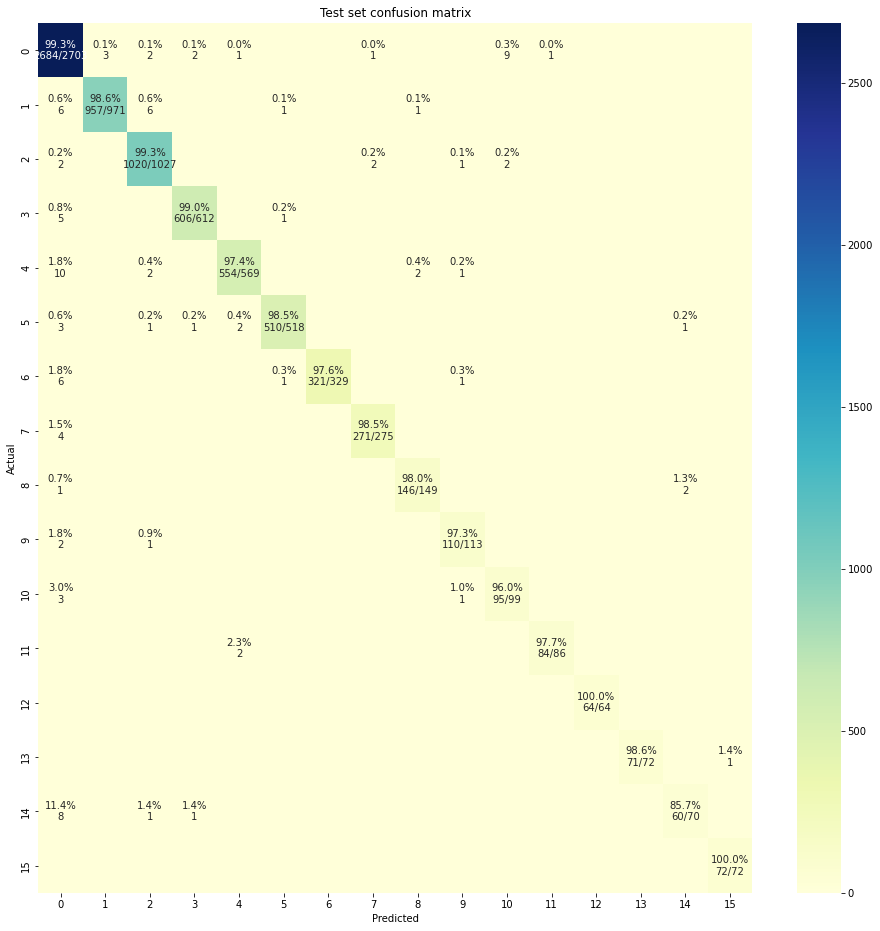

In [33]:
plot_cm(y_true, y_pred, title="Test set confusion matrix", figsize=(16,16), labels=labels.names)

# Conclusion, Next

Despite quite a few arbitrary shortcuts in the overall pipeline, we have a working template to fine-tune a pre-trained classification model to classify primary lithologies. 

I'll probably have to pause on this work for a few weeks, though perhaps a teaser Gradio app on Hugging Face spaces in the same vein as [this one](https://huggingface.co/spaces/j-m/formality_tagging) is diable with relatively little work. 

# Appendix

In [34]:

# Later on, in another post, for predictions on the CPU:
# model_cpu = model.to("cpu")

# from transformers import TextClassificationPipeline
# tokenizer = tokz

# pipe = TextClassificationPipeline(model=model_cpu, tokenizer=tokenizer, return_all_scores=True)
# # outputs a list of dicts like [[{'label': 'NEGATIVE', 'score': 0.0001223755971295759},  {'label': 'POSITIVE', 'score': 0.9998776316642761}]]

# pipe("clayey sand")

# raw_inputs = [
#     "I've been waiting for a HuggingFace course my whole life.",
#     "I hate this so much!",
# ]
# inputs = tokz(raw_inputs, padding=True, truncation=True, return_tensors="pt")
# print(inputs)

# pipe("I've been waiting for a HuggingFace course my whole life.")